In [1]:
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.utils as vutils

import glob
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from IPython.display import HTML

In [2]:
!pip install gdown
!gdown https://drive.google.com/uc?id=1ac8XGxGkNd_-n0wQyPzK-wxXDsFK0IHY
!gdown https://drive.google.com/uc?id=1sv8yy7o2OlrBNcHXIxDqcEvNW10wdWs2

  Installing build dependencies ... - \ | / done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
  Created wheel for gdown: filename=gdown-4.5.1-py3-none-any.whl size=14933 sha256=31e0c55e17e2291cd91b0c249962cb1dd59a7501645ecbbd50a6fa043a6d1068
  Stored in directory: /root/.cache/pip/wheels/3d/ec/b0/a96d1d126183f98570a785e6bf8789fca559853a9260e928e1
Successfully built gdown
Downloading...
From: https://drive.google.com/uc?id=1ac8XGxGkNd_-n0wQyPzK-wxXDsFK0IHY
To: /kaggle/working/Generator_v2_100.pth
100%|███████████████████████████████████████| 98.0M/98.0M [00:00<00:00, 106MB/s]
Downloading...
From: https://drive.google.com/uc?id=1sv8yy7o2OlrBNcHXIxDqcEvNW10wdWs2
To: /kaggle/working/Discriminator_v2_100.pth
100%|██████████████████████████████████████| 71.3M/71.3M [00:00<00:00, 96.1MB/s]


In [3]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        super().__init__()
        self.files = glob.glob(root_dir+"/*")
        self.transform = transform
    
    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        image = Image.open(self.files[idx]).convert("RGB")
        if self.transform is not None:
            image = self.transform(image)
        return image

In [4]:
dataroot = "../input/animefacedataset/images"
img_size=64
batch_size = 32
dataset = CustomDataset(root_dir=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize((img_size, img_size)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [5]:
class EqualLR:
    def __init__(self, name):
        self.name = name

    def compute_weight(self, module):
        weight = getattr(module, self.name + '_orig')
        fan_in = weight.data.size(1) * weight.data[0][0].numel()

        return weight * sqrt(2 / fan_in)

    @staticmethod
    def apply(module, name):
        fn = EqualLR(name)

        weight = getattr(module, name)
        del module._parameters[name]
        module.register_parameter(name + '_orig', nn.Parameter(weight.data))
        module.register_forward_pre_hook(fn)

        return fn

    def __call__(self, module, input):
        weight = self.compute_weight(module)
        setattr(module, self.name, weight)


def equal_lr(module, name='weight'):
    EqualLR.apply(module, name)

    return module

In [6]:
class EqualLinear(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()

        linear = nn.Linear(in_dim, out_dim)
        linear.weight.data.normal_()
        linear.bias.data.zero_()

        self.linear = equal_lr(linear)

    def forward(self, x):
        return self.linear(x)

In [7]:
class EqualConv2d(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()

        conv = nn.Conv2d(*args, **kwargs)
        conv.weight.data.normal_()
        conv.bias.data.zero_()
        self.conv = equal_lr(conv)

    def forward(self, input):
        return self.conv(input)

In [8]:
class ConstantInput(nn.Module):
    def __init__(self, channel, size=4):
        super().__init__()

        self.input = nn.Parameter(torch.randn(1, channel, size, size))

    def forward(self, x):
        batch = x.shape[0]
        out = self.input.repeat(batch, 1, 1, 1)
        return out

In [9]:
class NoiseInjection(nn.Module):
    def __init__(self, channel):
        super().__init__()

        self.weight = nn.Parameter(torch.zeros(1, channel, 1, 1))

    def forward(self, image, noise):
        return image + self.weight * noise

In [10]:
class AdaptiveInstanceNorm(nn.Module):
    def __init__(self, in_channel, style_dim):
        super().__init__()

        self.norm = nn.InstanceNorm2d(in_channel)
        self.style = nn.Linear(style_dim, in_channel * 2)
        self.style.bias.data[:in_channel] = 1
        self.style.bias.data[in_channel:] = 0

    def forward(self, input, style):
        style = self.style(style).unsqueeze(2).unsqueeze(3)
        gamma, beta = style.chunk(2, 1)

        out = self.norm(input)
        out = gamma * out + beta

        return out

In [11]:
class BlurFunctionBackward(Function):
    @staticmethod
    def forward(ctx, grad_output, kernel, kernel_flip):
        ctx.save_for_backward(kernel, kernel_flip)

        grad_input = F.conv2d(
            grad_output, kernel_flip, padding=1, groups=grad_output.shape[1]
        )

        return grad_input

    @staticmethod
    def backward(ctx, gradgrad_output):
        kernel, kernel_flip = ctx.saved_tensors

        grad_input = F.conv2d(
            gradgrad_output, kernel, padding=1, groups=gradgrad_output.shape[1]
        )

        return grad_input, None, None


class BlurFunction(Function):
    @staticmethod
    def forward(ctx, input, kernel, kernel_flip):
        ctx.save_for_backward(kernel, kernel_flip)

        output = F.conv2d(input, kernel, padding=1, groups=input.shape[1])

        return output

    @staticmethod
    def backward(ctx, grad_output):
        kernel, kernel_flip = ctx.saved_tensors

        grad_input = BlurFunctionBackward.apply(grad_output, kernel, kernel_flip)

        return grad_input, None, None


blur = BlurFunction.apply


class Blur(nn.Module):
    def __init__(self, channel):
        super().__init__()

        weight = torch.tensor([[1, 2, 1], [2, 4, 2], [1, 2, 1]], dtype=torch.float32)
        weight = weight.view(1, 1, 3, 3)
        weight = weight / weight.sum()
        weight_flip = torch.flip(weight, [2, 3])

        self.register_buffer('weight', weight.repeat(channel, 1, 1, 1))
        self.register_buffer('weight_flip', weight_flip.repeat(channel, 1, 1, 1))

    def forward(self, input):
        return blur(input, self.weight, self.weight_flip)

In [12]:
class StyledConvBlock(nn.Module):
    def __init__(
        self,
        in_channel,
        out_channel,
        kernel_size=3,
        padding=1,
        style_dim=512,
        initial=False,
        upsample=False
    ):
        super().__init__()

        if initial:
            self.conv1 = ConstantInput(in_channel)

        else:
            if upsample:
                self.conv1 = nn.Sequential(
                    nn.Upsample(scale_factor=2, mode='nearest'),
                    EqualConv2d(
                        in_channel, out_channel, kernel_size, padding=padding
                    ),
                    Blur(out_channel),
                )
            else:
                self.conv1 = EqualConv2d(
                    in_channel, out_channel, kernel_size, padding=padding
                )

        self.noise1 = NoiseInjection(out_channel)
        self.adain1 = AdaptiveInstanceNorm(out_channel, style_dim)
        self.lrelu1 = nn.LeakyReLU(0.2)

        self.conv2 = EqualConv2d(out_channel, out_channel, kernel_size, padding=padding)
        self.noise2 = NoiseInjection(out_channel)
        self.adain2 = AdaptiveInstanceNorm(out_channel, style_dim)
        self.lrelu2 = nn.LeakyReLU(0.2)

    def forward(self, x, style, noise):
        out = self.conv1(x)
        out = self.noise1(out, noise)
        out = self.lrelu1(out)
        out = self.adain1(out, style)

        out = self.conv2(out)
        out = self.noise2(out, noise)
        out = self.lrelu2(out)
        out = self.adain2(out, style)

        return out

In [13]:
class Generator(nn.Module):
    def __init__(self, z_dim=512, n_linear=5):
        super(Generator, self).__init__()
        layers = []
        for i in range(n_linear):
            layers.append(EqualLinear(z_dim, z_dim))
            layers.append(nn.LeakyReLU(0.2))
        self.style = nn.Sequential(*layers)
        self.progression = nn.ModuleList(
            [
              StyledConvBlock(512, 512, 3, 1, initial=True),
              StyledConvBlock(512, 512, 3, 1, upsample=True),
              StyledConvBlock(512, 256, 3, 1, upsample=True),
              StyledConvBlock(256, 128, 3, 1, upsample=True),
              StyledConvBlock(128, 64, 3, 1, upsample=True),
            ]
        )
        self.to_rgb = EqualConv2d(64, 3, 1)

    def forward(self, x, noise=None, step=0):
        batch = x.size(0)
        if noise is None:
            noise = []
            for i in range(step + 1):
                size = 4 * 2 ** i
                noise.append(torch.randn(batch, 1, size, size, device=x[0].device))
        x = x / torch.sqrt(torch.mean(x ** 2, dim=1, keepdim=True) + 1e-8)
        styles = self.style(x)
        out = noise[0]
        for i, conv in enumerate(self.progression):
            out = self.progression[i](out, styles, noise[i])
        return self.to_rgb(out)

In [14]:
class ConvBlock(nn.Module):
    def __init__(
        self,
        in_channel,
        out_channel,
        kernel_size,
        padding,
        downsample=False,
        fused=False
    ):
        super().__init__()
        self.conv1 = nn.Sequential(
            EqualConv2d(in_channel, out_channel, kernel_size, padding=padding),
            nn.LeakyReLU(0.2),
        )

        if downsample:
            self.conv2 = nn.Sequential(
                Blur(out_channel),
                EqualConv2d(out_channel, out_channel, kernel_size, padding=padding),
                nn.AvgPool2d(2),
                nn.LeakyReLU(0.2),
            )

        else:
            self.conv2 = nn.Sequential(
                EqualConv2d(out_channel, out_channel, kernel_size, padding=padding),
                nn.LeakyReLU(0.2),
            )

    def forward(self, input):
        out = self.conv1(input)
        out = self.conv2(out)

        return out

In [15]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            EqualConv2d(3, 32, 1), 
            nn.LeakyReLU(0.2),
            ConvBlock(32, 64, 3, 1, downsample=True),
            ConvBlock(64, 128, 3, 1, downsample=True),
            ConvBlock(128, 256, 3, 1, downsample=True),
            ConvBlock(256, 512, 3, 1, downsample=True),
            EqualConv2d(512, 512, 4, padding=0),
            nn.LeakyReLU(0.2),
        )
        self.linear = nn.Linear(512, 1)
    
    def forward(self, x):
        x = self.conv(x).reshape(x.size(0), -1)
        return torch.sigmoid(self.linear(x))

tensor([[0.9556],
        [0.0294],
        [0.0402],
        [0.0106],
        [0.2824],
        [0.0547],
        [0.1738],
        [0.4688],
        [0.4113],
        [0.0040],
        [0.1099],
        [0.0415],
        [0.0104],
        [0.0196],
        [0.0374],
        [0.0299]], device='cuda:0', grad_fn=<SigmoidBackward0>)

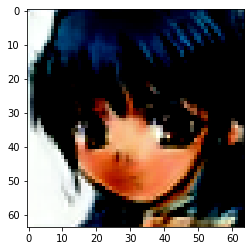

In [16]:
import math
from math import sqrt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
g_path = "Generator_v2_100.pth"
if g_path is None:
    G = Generator().to(device)
else:
    G = torch.load(g_path, map_location=device)
z = torch.randn(16, 512).to(device)
step = int(math.log(64,2))-2
out = G(z, step=step)


plt.imshow(out[0].permute([1,2,0]).detach().cpu().numpy())
d_path = "Discriminator_v2_100.pth"
if d_path is None:
    D = Discriminator().to(device)
else:
    D = torch.load(d_path, map_location=device)
D(out)

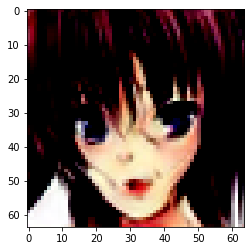

In [17]:
plt.imshow(out[1].permute([1,2,0]).detach().cpu().numpy())

In [18]:
sum(p.numel() for p in D.parameters())

8897537

In [19]:
sum(p.numel() for p in G.parameters())

13747907

In [20]:
num_epochs=50
lr = 3e-4
step = int(math.log(64,2))-2
real_label = 1.
fake_label = 0.

criterion = nn.BCELoss()
dim_z = 512

optimizerD = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))

fixed_noise = torch.randn(64, dim_z, device=device)

In [21]:
iters = 0
G_losses = []
D_losses = []
img_list = []
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        D.zero_grad()
        # Format batch
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = D(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, dim_z, device=device)
        # Generate fake image batch with G
        fake = G(noise, step=step)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = D(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        G.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = D(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = G(fixed_noise, step=step).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True)) 
        iters += 1

[0/50][0/1987]	Loss_D: 0.3564	Loss_G: 4.9285	D(x): 0.8833	D(G(z)): 0.1195 / 0.0171
[0/50][50/1987]	Loss_D: 0.3007	Loss_G: 4.5731	D(x): 0.9622	D(G(z)): 0.1667 / 0.0207
[0/50][100/1987]	Loss_D: 0.5800	Loss_G: 3.4082	D(x): 0.8335	D(G(z)): 0.2011 / 0.0618
[0/50][150/1987]	Loss_D: 0.2079	Loss_G: 3.6613	D(x): 0.9521	D(G(z)): 0.1237 / 0.0447
[0/50][200/1987]	Loss_D: 0.3289	Loss_G: 4.0347	D(x): 0.9375	D(G(z)): 0.1729 / 0.0286
[0/50][250/1987]	Loss_D: 0.3868	Loss_G: 3.3991	D(x): 0.8056	D(G(z)): 0.0446 / 0.1130
[0/50][300/1987]	Loss_D: 0.4074	Loss_G: 3.2975	D(x): 0.8160	D(G(z)): 0.0726 / 0.0711
[0/50][350/1987]	Loss_D: 0.3806	Loss_G: 2.2754	D(x): 0.8109	D(G(z)): 0.0863 / 0.1594
[0/50][400/1987]	Loss_D: 0.4948	Loss_G: 3.5942	D(x): 0.7674	D(G(z)): 0.0667 / 0.0842
[0/50][450/1987]	Loss_D: 0.2323	Loss_G: 5.9453	D(x): 0.9444	D(G(z)): 0.1241 / 0.0116
[0/50][500/1987]	Loss_D: 0.3600	Loss_G: 3.2176	D(x): 0.8322	D(G(z)): 0.0894 / 0.1008
[0/50][550/1987]	Loss_D: 0.6142	Loss_G: 4.8235	D(x): 0.9237	D(G(z)):

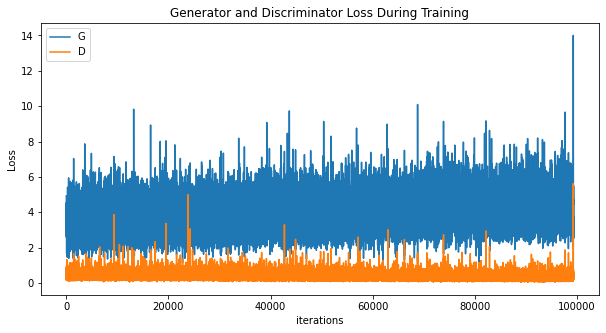

In [22]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

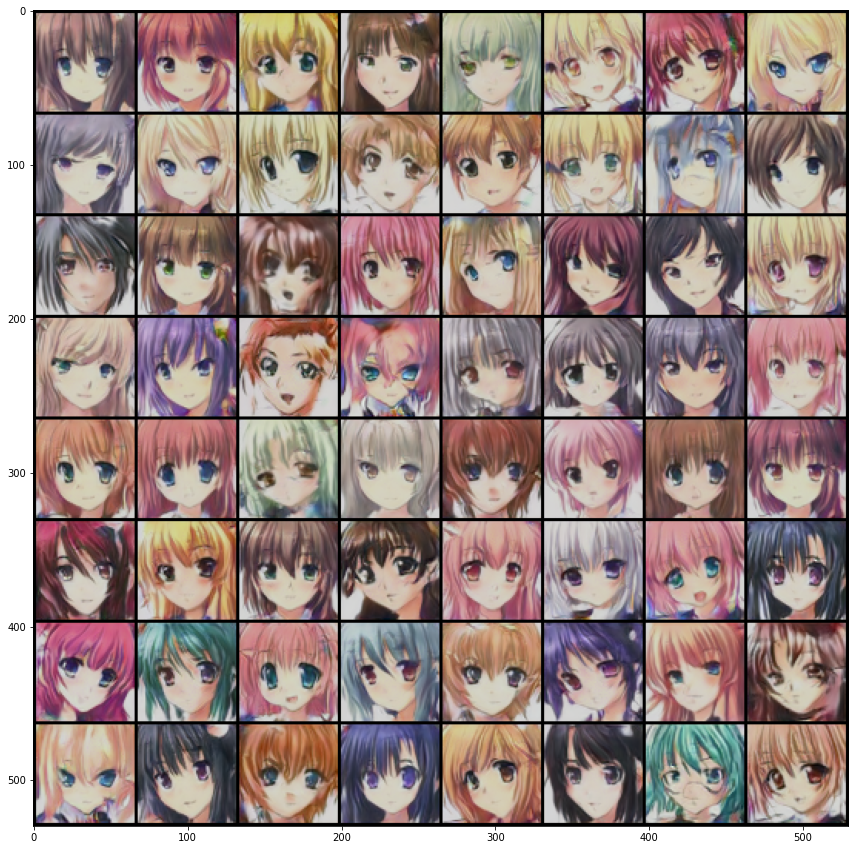

In [23]:
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(img_list[-1],(1,2,0)))

tensor([[[ 0.6644,  0.4275,  0.3767,  ...,  0.3749,  0.4773,  0.5608],
         [ 0.5468, -0.0782,  0.4150,  ...,  0.5466,  0.4654,  0.6668],
         [ 0.1505, -0.0952,  0.9925,  ...,  0.9089,  0.7975,  0.7328],
         ...,
         [ 0.1503,  0.0365,  0.0095,  ...,  0.2821,  0.1984, -0.0529],
         [ 0.0818, -0.0097, -0.0289,  ...,  0.1304,  0.3453,  0.3016],
         [ 0.0487,  0.0253,  0.0197,  ...,  0.4999,  0.4475,  0.3975]],

        [[ 0.4029,  0.2178,  0.1805,  ...,  0.3486,  0.5951,  0.7032],
         [ 0.2553, -0.2568,  0.3045,  ...,  0.4161,  0.3810,  0.6930],
         [-0.1424, -0.3000,  0.8753,  ...,  0.7535,  0.6247,  0.6354],
         ...,
         [ 0.1496,  0.0275,  0.0045,  ...,  0.2005,  0.1361, -0.1015],
         [ 0.0473, -0.0094, -0.0258,  ...,  0.1380,  0.2913,  0.2572],
         [ 0.0476,  0.0215,  0.0448,  ...,  0.3420,  0.2926,  0.3108]],

        [[ 0.1584, -0.1539, -0.3914,  ...,  0.1076,  0.5032,  0.6508],
         [-0.1982, -0.7902, -0.4486,  ...,  0

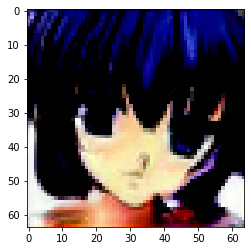

In [24]:
import math
z = torch.randn(16, 512).to(device)
step = int(math.log(64, 2)) - 2
out = G(z, step=step)
print(out[1]-out[0])
plt.imshow(out[0].permute([1,2,0]).detach().cpu().numpy())
p = D(out)

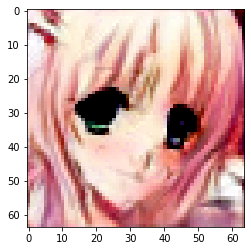

In [25]:
plt.imshow(out[p.argmax()].permute([1,2,0]).detach().cpu().numpy())

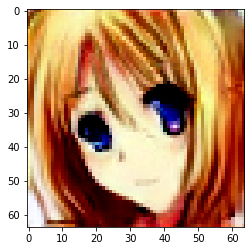

In [26]:
plt.imshow(out[1].permute([1,2,0]).detach().cpu().numpy())

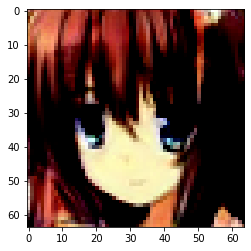

In [27]:
plt.imshow(fake[0].permute([1,2,0]).detach().cpu().numpy())

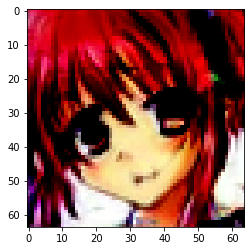

In [28]:
plt.imshow(fake[D(fake.to(device)).argmax()].permute([1,2,0]).detach().cpu().numpy())

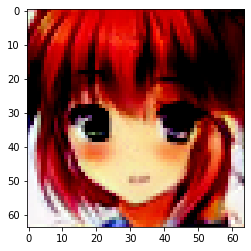

In [29]:
plt.imshow(fake[1].permute([1,2,0]).detach().cpu().numpy())

In [30]:
torch.save(G, "Generator.pth")
torch.save(D, "Discriminator.pth")